# NBA Playoffs
* **See the main project notebook for instructions to be sure you satisfy the rubric!**
* See project 03 for information on the dataset.
* A few example prediction questions to pursue are listed below. However, don't limit yourself to them!
    * Will a player/team make the playoffs this season? (try training on previous year!)
    * Predict players' "playoff performance" based on the regular statistics.
    * Guess the number of games a team will win in a season based on player statistics (need to aggregate statistics to a team-level).


Be careful to justify what information you would know at the "time of prediction" and train your model using only those features.

---
# Summary of Findings


## Introduction
---




### Results: Baseline Model
---



### Results: Final Model
---



### Results: Fairness Evaluation
---


---

# Your Code Starts Here

In [128]:
%matplotlib inline
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plot
import seaborn as sns

from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics

In [129]:
fp = os.path.join('data', 'basketball_data.csv')
data = pd.read_csv(fp)

In [130]:
#get the shape of the original data to verify rows have been successfully dropped
print("Original shape: " + str(data.shape))

cleaned = data.copy()
#drop the rows with index where "Tm" is "TOT"
cleaned.drop(cleaned.loc[cleaned['Tm'] == "TOT"].index, inplace = True)
#get the new shape of the cleaner data to verify rows have been successfully dropped
print("New shape: " + str(cleaned.shape))

#map data to the cleaner dataframe
data = cleaned

Original shape: (4223, 55)
New shape: (3836, 55)


In [131]:
#get the shape of the original data to verify rows have been successfully dropped
print("Original shape: " + str(data.shape))

#get only the columns from the regular season
cols = [c for c in data.columns if 'playoff' not in c]
#add in the G_playoff column to our list of columns
cols.append('G_playoff')
#map the dataset to the dataframe containing only the columns of interest
data = data[cols]

#get the new shape of the cleaner data to verify rows have been successfully dropped
print("New shape: " + str(data.shape))

Original shape: (3836, 55)
New shape: (3836, 31)


In [132]:
#get the shape of the original data to verify rows have been successfully dropped
print("Original shape: " + str(data.shape))

#get only the columns from the regular season
cols = [c for c in data.columns if '%' not in c]
#map the dataset to the dataframe containing only the columns of interest
data = data[cols]

#get the new shape of the cleaner data to verify rows have been successfully dropped
print("New shape: " + str(data.shape))


Original shape: (3836, 31)
New shape: (3836, 26)


In [146]:
for col in data.columns:
    if data[col].dtype == int:
        data[col] = data[col].astype(np.float32)

data.dtypes

Year               int64
Pos               object
Age                int64
Tm                object
G_reg_season       int64
GS_reg_season      int64
MP_reg_season      int64
FG_reg_season      int64
FGA_reg_season     int64
3P_reg_season      int64
3PA_reg_season     int64
2P_reg_season      int64
2PA_reg_season     int64
FT_reg_season      int64
FTA_reg_season     int64
ORB_reg_season     int64
DRB_reg_season     int64
TRB_reg_season     int64
AST_reg_season     int64
STL_reg_season     int64
BLK_reg_season     int64
TOV_reg_season     int64
PF_reg_season      int64
PTS_reg_season     int64
G_playoff          int64
dtype: object

In [137]:
binary = data['G_playoff'].apply(lambda x: 1 if x > 0 else 0)
data = data.drop(['G_playoff', 'Player'], axis = 1)
data['G_playoff'] = binary
data.head()

,Year,Pos,Age,Tm,G_reg_season,GS_reg_season,MP_reg_season,FG_reg_season,FGA_reg_season,3P_reg_season,...,ORB_reg_season,DRB_reg_season,TRB_reg_season,AST_reg_season,STL_reg_season,BLK_reg_season,TOV_reg_season,PF_reg_season,PTS_reg_season,G_playoff
0,2012,PF,25,HOU,8,0,63,7,16,0,...,5,17,22,1,0,2,2,13,21,0
1,2012,SG,26,DEN,62,62,2086,329,699,88,...,40,157,197,149,36,13,85,134,943,1
2,2012,PG,27,UTA,4,0,30,4,14,2,...,0,2,2,1,0,0,5,4,10,1
3,2012,C,23,TOR,14,0,122,13,36,0,...,15,32,47,3,2,9,5,11,33,0
4,2012,C,23,OKC,26,0,173,22,42,0,...,13,35,48,3,8,16,9,22,57,1


### Results: Baseline Model
---

In [147]:
#split the data 80-20
X_train, X_test, y_train, y_test = train_test_split(data.drop("G_playoff", axis = 1), data.G_playoff, test_size = .2) 

In [191]:
#columns for categorical transformation
to_ohe = ['Pos', 'Tm']
ohe_transformer = Pipeline([('one-hot', OneHotEncoder())])

#put transformers into a column transformer
preprocessor = ColumnTransformer(transformers = [('cat', ohe_transformer, to_ohe)], 
                                 remainder = 'passthrough')

#make and fit the baseline pipeline
baseline_pl = Pipeline([('preprocess', preprocessor), 
                        ('cls', RandomForestClassifier(n_estimators=3))])
baseline_pl.fit(X_train, y_train)

#predict whether or not a player is in the playoffs
pred = baseline_pl.predict(X_test)


In [192]:
#show the percentage we got correct
display('approximately '+ 
        str(round(metrics.accuracy_score(y_test, pred) * 100, 2)) + 
        '% correctly classified')


'approximately 70.31% correctly classified'

In [193]:
#get the precision and recall of our model
baseline_precision = metrics.precision_score(y_test, pred)
baseline_recall = metrics.recall_score(y_test, pred)

baseline_f1 = 2 * ((baseline_precision * baseline_recall) / (baseline_precision + baseline_recall))
display('current F1 score: '+ str(baseline_f1))


'current F1 score: 0.5928571428571429'

### Results: Final Model
---

In [184]:
from sklearn.base import BaseEstimator, TransformerMixin
class StdScalerYr(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        # X may not be a pandas dataframe (e.g. a np.array)
        df = pd.DataFrame(X)
        
        # A dictionary of means/standard-deviations for each column, for each group.
        self.grps_ = df.groupby('Year').agg(['std', 'mean']).to_dict()
        return self
    
    def transform(self, X, y=None):
        #check if the transformer has been fit
        try:
            getattr(self, "grps_")
        except AttributeError:
            raise RuntimeError("You must fit the transformer before tranforming the data!")
        

        #helper to standardize
        def scale_helper(df):
            
            def to_zscore(col):
                grp_mean = self.grps_[(col.name, 'mean')][df.name]
                grp_std = self.grps_[(col.name, 'std')][df.name]
                return (col - grp_mean) / grp_std
            
            return df.apply(to_zscore)

        df = pd.DataFrame(X)
        
        return df.groupby('Year').apply(scale_helper)


In [186]:
def scale(df):
    scaler = StdScalerYr().fit(df[['Year', 'MP_reg_season', 'PTS_reg_season']])
    return scaler.transform(df[['Year', 'MP_reg_season', 'PTS_reg_season']])

to_num = ['Year', 'MP_reg_season', 'PTS_reg_season']
num_transformer = Pipeline([('standardize', FunctionTransformer(scale, validate = False))])

#columns for categorical transformation
to_ohe = ['Pos', 'Tm']
ohe_transformer = Pipeline([('one-hot', OneHotEncoder())])

#put transformers into a column transformer
preprocessor = ColumnTransformer(transformers = [('cat', ohe_transformer, to_ohe), 
                                                 ('num', num_transformer, to_num)], 
                                 remainder = 'passthrough')

#make and fit the baseline pipeline
final_pl = Pipeline([('preprocess', preprocessor), 
                        ('cls', RandomForestClassifier(n_estimators=3))])

final_pl.fit(X_train, y_train)

#predict whether or not a player is in the playoffs
final_pred = final_pl.predict(X_test)


In [187]:
#show the percentage we got correct
display('approximately '+ 
        str(round(metrics.accuracy_score(y_test, final_pred) * 100, 2)) + 
        '% correctly classified in final model')


'approximately 67.19% correctly classified in final model'

In [190]:
metrics.f1_score(y_test, final_pred)

0.5516014234875445

### Results: Fairness Evaluation
---

In [162]:
results = X_test
results['prediction'] = final_pred
results['tag'] = y_test

In [196]:
results['is_starter'] = ((data['GS_reg_season'] / data['G_reg_season']) > 0.5).replace({True:'starter', False:'not starter'})

results.groupby('is_starter').prediction.mean().to_frame()

,prediction
is_starter,
not starter,0.309160
starter,0.520492


In [164]:
(
    results
    .groupby('is_starter')
    .apply(lambda x: metrics.accuracy_score(x.tag, x.prediction))
    .rename('accuracy')
    .to_frame()
)

,accuracy
is_starter,
not starter,0.694656
starter,0.668033


In [165]:
obs = results.groupby('is_starter').apply(lambda x: metrics.accuracy_score(x.tag, x.prediction)).diff().iloc[-1]

metrs = []
for _ in range(500):
    s = (
        results[['is_starter', 'prediction', 'tag']]
        .assign(is_starter = results['is_starter'].sample(frac=1.0, replace=False).reset_index(drop=True))
        .groupby('is_starter')
        .apply(lambda x: metrics.accuracy_score(x.tag, x.prediction))
        .diff()
        .iloc[-1]
    )
    
    metrs.append(s)

0.37


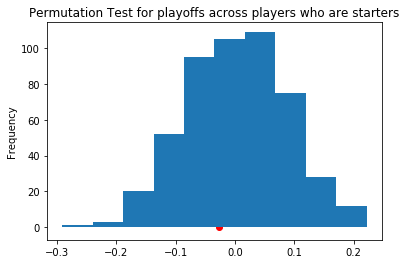

In [166]:
print(pd.Series(metrs <= obs).mean())
pd.Series(metrs).plot(kind='hist', title='Permutation Test for playoffs across players who are starters')
plot.scatter(obs, 0, c='r');

In [167]:
(
    results
    .groupby('is_starter')
    .apply(lambda x: metrics.recall_score(x.tag, x.prediction))
    .rename('recall_score')
    .to_frame()
)

,recall_score
is_starter,
not starter,0.505814
starter,0.709091


In [168]:
obs = results.groupby('is_starter').apply(lambda x: metrics.recall_score(x.tag, x.prediction)).diff().iloc[-1]

metrs = []
for _ in range(500):
    s = (
        results[['is_starter', 'prediction', 'tag']]
        .assign(is_starter = results['is_starter'].sample(frac=1.0, replace=False).reset_index(drop=True))
        .groupby('is_starter')
        .apply(lambda x: metrics.recall_score(x.tag, x.prediction))
        .diff()
        .iloc[-1]
    )
    
    metrs.append(s)

0.936


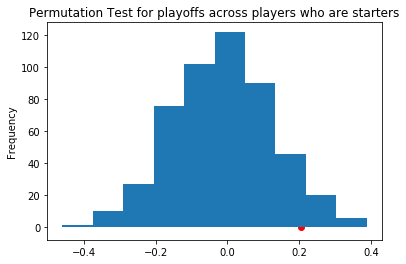

In [169]:
print(pd.Series(metrs <= obs).mean())
pd.Series(metrs).plot(kind='hist', title='Permutation Test for playoffs across players who are starters')
plot.scatter(obs, 0, c='r');